<a href="https://colab.research.google.com/github/lkamimura/SimulacionDinamica/blob/main/Clase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de Octave en el entorno Colab
Se instala el programa Octave, y las librerías necesarias.

In [1]:
# !apt-get update #Usar para actualizar librerias, únicamente
from IPython import display
!apt install octave #Instala colab en el entorno de trabajo
!apt install octave python3-sympy #Instala el paquete simbólico de Octave, que incluye el Sympy de Python
display.clear_output()

In [2]:
%%writefile Inst_S.m
pkg install -forge symbolic

Overwriting Inst_S.m


In [3]:
!octave -W Inst_S.m #corre el código adentro de Octave pkg install -forge symbolic

For information about changes from previous versions of the symbolic package, run 'news symbolic'.


In [4]:
!pip install --user sympy==1.5.1 #Normalmente no es necesario, pero ésta versión actual de "octave-symbolic" lo exige
display.clear_output()

In [5]:
# No anda !pip install --user sympy==1.11 #Normalmente no es necesario, pero ésta versión actual de "octave-symbolic" lo exige

Se debe agregar en el .m el path donde está el Python, mediante una línea como ésta:

---


**setenv PYTHON /usr/local/bin/python**


---


para acceder al sympy desde symbolic. No obtante, puede ser diferente el path y debe verificarse en caso de que no funcione.


# Solución simbólica en un circuito RLC

Se resuelve la ecuacion diferencial del circuito RLC de la figura.

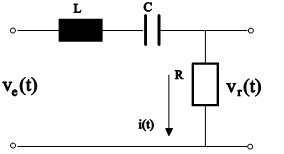

Las ecuaciones son
<!-- $(M+m)\cdot\ddot{\delta} = u- m\cdot long \cdot \ddot{\phi} + m\cdot long \cdot \dot{\phi}^2 \cdot \phi -Fricc\cdot \dot{\delta}$,
$Long \cdot \ddot{\phi} = g \cdot \phi - \ddot{\delta}$ -->
$\begin{equation*}
\begin{cases}
\frac{di(t)}{dt}=-\frac{R}{L}i(t)-\frac{1}{L}v_c(t) + \frac{1}{L}v_e(t)  \\
\frac{dv_c(t)}{dt}=\frac{1}{C}i(t)
\end{cases}
\end{equation*} \tag*{}$

con las condiciones iniciales nulas para la corriente $i(0)=0$ y la tensión del capacitor $v_c(0)=0$.

#RLC SIMBOLICO UNITARIO

In [6]:
%%writefile Calculo_RLC_Simbolico.m
clear all; clc;warning('off','all');
setenv PYTHON /usr/local/bin/python %Acá está el vinculo con Pyton, para acceder al sympy desde symbolic
%/usr/bin/python
pkg load symbolic %Primera vez que se corre el paquete simbólico de Python.
% #R=2.2e3;L=10e-6;C=100e-9;
syms ii(t) v(t)
ode2=diff(v)==ii;
% ode1=diff(ii)==-R/L*ii-1/L*v+1/L*heaviside(0);
ode1=diff(ii)==-ii-v+heaviside(0,1);%heaviside(0) devuelve .5
cond1 = ii(0) == 0;
cond2 = v(0) == 0;
conds = [cond1;cond2];
odes = [ode1; ode2];
Sol=dsolve(odes,ii(0) == .0,v(0) == .0);
Corriente=simplify(Sol.ii)
Tension=simplify(Sol.v)

hfig1 = figure(1); set(hfig1, 'Visible', 'off');
t=0:0.001:20;
I=2./3.*sqrt(3).*e.^(-t./2).*sin(sqrt(3).*t./2);
subplot(2,1,1);plot(t,I*12);title('RLC simbolico unitario');xlabel('t[s]');ylabel('x_1 Corriente[A]');
V=1-(2./3.*sqrt(3).*e.^(-t./2).*sin((sqrt(3).*t./2)+pi./3));
subplot(2,1,2);plot(t,V*12);xlabel('t[s]');ylabel('x_2 Tension[V]');
print -dpng rlc_sim.png

Overwriting Calculo_RLC_Simbolico.m


Luego de generar el archivo .m en el entorno, se puede ejecutar al Octave con los comandos de línea.

Symbolic pkg v3.2.1: Python communication link active, SymPy v1.5.1.
Corriente = (sym)

        -t           
        ───          
         2     ⎛√3⋅t⎞
  2⋅√3⋅ℯ   ⋅sin⎜────⎟
               ⎝ 2  ⎠
  ───────────────────
           3         

Tension = (sym)

            -t               
            ───              
             2     ⎛√3⋅t   π⎞
      2⋅√3⋅ℯ   ⋅sin⎜──── + ─⎟
                   ⎝ 2     3⎠
  1 - ───────────────────────
                 3           




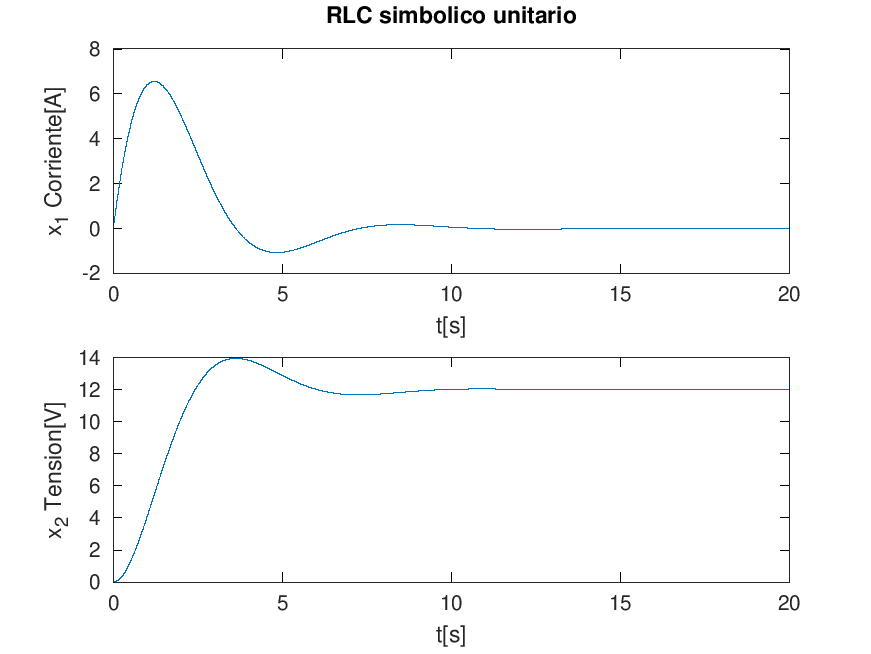

In [7]:
!octave -W Calculo_RLC_Simbolico.m # -W : no window system
display.Image('rlc_sim.png')

#RLC NUMERICO UNITARIO

In [8]:
%%writefile Calculo_RLC_Numerico.m
clear all; clc;close all;
pkg load symbolic;warning('off','all');
setenv PYTHON /usr/local/bin/python %Acá está el vinculo con Pyton, para acceder al sympy desde symbolic
%/usr/bin/python

%Funcion modelo
function [X]=modrlc(t_etapa, xant, accion)
##h=1e-9;t_simul=1e-3;R=2.2e3;L=10e-6;C=100e-9;
h=0.001;t_simul=20;R=1;L=1;C=1; %UNITARIO
##h=1e-9;t_simul=1e-3;R=2.2e3;L=10e-6;C=100e-9;
A=[-R/L, -1/L;1/C,0];B=[1/L;0];%
% eig(A)
% 1./ans
C=[R 0];u=accion;
x=xant;
for ii=1:t_etapa/h
xp=A*x+B*u;
x=x+xp*h;
end
X=[x];%x1 corriente, x2 tensión
endfunction

X=-[0; 0];ii=0;t_etapa=0.001;wRef=2;tF=20;
color_='r';
Ts=t_etapa;
%A1=((2*Kp*Ts)+(Ki*(Ts^2))+(2*Kd))/(2*Ts);
%B1=(-2*Kp*Ts+Ki*(Ts^2)-4*Kd)/(2*Ts);
%C1=Kd/Ts;
%e=zeros(round(tF/t_etapa),1);
u=1;TL=1.15e-4;u=12;
##graphics_toolkit("qt"); %Aconsejado
##graphics_toolkit("gnuplot");

for t=0:t_etapa:tF
ii=ii+1;k=ii+2;
x1(ii)=X(1);%corriente
x2(ii)=X(2);%tensión en el capacitor
X=modrlc(t_etapa, X, u);
acc(ii)=u;
end

hfig1 = figure(1); set(hfig1, 'Visible', 'off');
t=0:t_etapa:tF;
subplot(3,1,1);hold on;
plot(t,x1,color_);xlabel('t[s]');ylabel('x_1 Corriente[A]');
title('RLC Numerico Unitario')
subplot(3,1,2);hold on;
plot(t,x2,color_);xlabel('t[s]');ylabel('x_2 Tension[V]');
subplot(3,1,3);hold on;
plot(t,acc,color_);xlabel('t[s]');ylabel('u_t Entrada[V]');
print -dpng rlc_num.png

Overwriting Calculo_RLC_Numerico.m


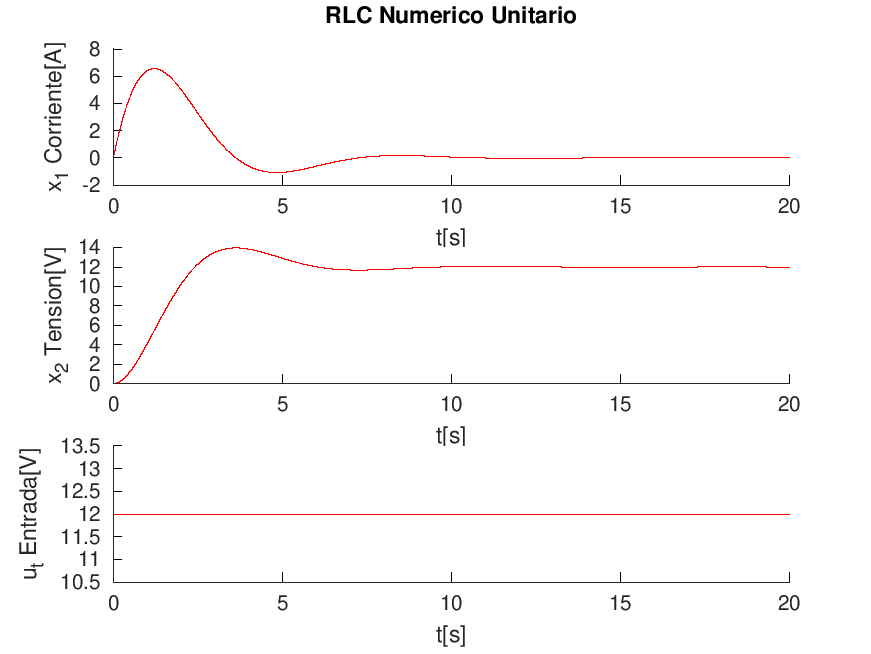

In [9]:
!octave -W Calculo_RLC_Numerico.m # -W : no window system
display.Image('rlc_num.png')

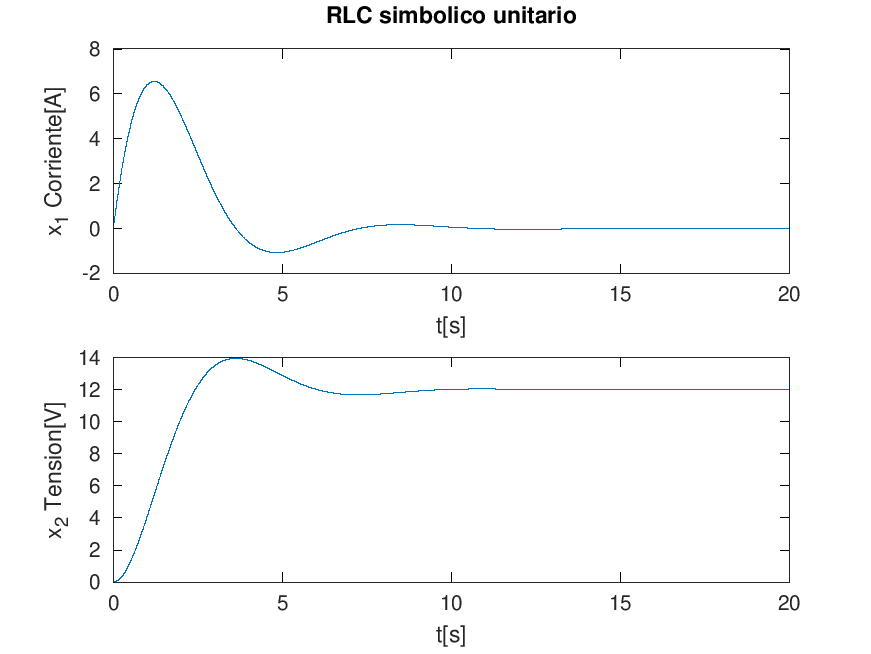

In [10]:
display.Image('rlc_sim.png')

#R=2,2K, L=10uHy, C=100nF

In [11]:
%%writefile Calculo_RLC_NumTP.m
clear all; clc;close all;
pkg load symbolic;warning('off','all');
setenv PYTHON /usr/local/bin/python %Acá está el vinculo con Pyton, para acceder al sympy desde symbolic
%/usr/bin/python

%Funcion modelo
function [X]=modrlc(t_etapa, xant, accion)
h=1e-9;t_simul=1e-3;R=2.2e3;L=10e-6;C=100e-9;
A=[-R/L, -1/L;1/C,0];B=[1/L;0];%
% eig(A)
% 1./ans
C=[R 0];u=accion;
x=xant;
for ii=1:t_etapa/h
xp=A*x+B*u;
x=x+xp*h;
end
X=[x];%x1 corriente, x2 tensión
endfunction

X=-[0; 0];ii=0;t_etapa=1e-8;wRef=2;tF=1e-3;
color_='r';
Ts=t_etapa;u=12;
graphics_toolkit("gnuplot");

for t=0:t_etapa:tF
ii=ii+1;k=ii+2;
x1(ii)=X(1);%corriente
x2(ii)=X(2);%tensión en el capacitor
X=modrlc(t_etapa, X, u);
acc(ii)=u;
end

hfig1 = figure(1); set(hfig1, 'Visible', 'off');
t=0:t_etapa:tF;
subplot(3,1,1);hold on;title('RLC Simulacion');
plot(t,x1,color_);ylabel('x_1 corriente');
subplot(3,1,2);hold on;
plot(t,x2,color_);ylabel('x_2 Vc_t');
subplot(3,1,3);hold on;
plot(t,acc,color_);ylabel('Entrada u_t, v_a');
xlabel('t[s]');
print -dpng rlc_numTP.png

Overwriting Calculo_RLC_NumTP.m


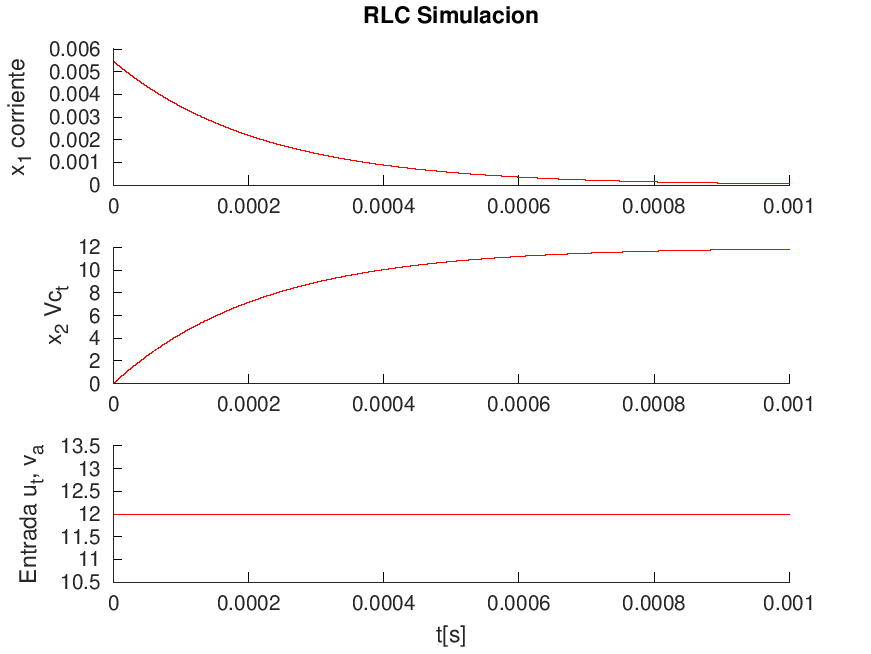

In [12]:
!octave -W Calculo_RLC_NumTP.m # -W : no window system
display.Image('rlc_numTP.png')

#Punto 3

In [18]:
%%writefile Calculo_RLC_NumTP3.m
clear all; clc;close all;
setenv PYTHON /usr/local/bin/python %Acá está el vinculo con Pyton, para acceder al sympy desde symbolic
%/usr/bin/python

function [X]=modrlc(t_etapa, xant, accion)
h=1e-9;t_simul=1e-3;R=2.2e3;L=10e-6;C=100e-9;
A=[-R/L, -1/L;1/C,0];B=[1/L;0];%
% eig(A)
% 1./ans
C=[R 0];u=accion;
x=xant;
for ii=1:t_etapa/h
xp=A*x+B*u;
x=x+xp*h;
end
X=[x];%x1 corriente, x2 tensión
endfunction

X=-[0; 0];ii=0;t_etapa=1e-8;wRef=2;tF=4e-3;
color_='r';
Ts=t_etapa;u=12;
ti=0:t_etapa:tF;
u=12 * (ti <= 1e-3) - 12 * (ti > 1e-3 & ti <= 2e-3) + 12 * (ti > 2e-3& ti <= 3e-3)- 12 * (ti >= 3e-3 & ti <= 4e-3);
graphics_toolkit("gnuplot");

for t=0:t_etapa:tF
ii=ii+1;k=ii+2;
x1(ii)=X(1);%corriente
x2(ii)=X(2);%tensión en el capacitor
X=modrlc(t_etapa, X, u(ii));
acc(ii)=u(ii);
end

hfig1 = figure(1); set(hfig1, 'Visible', 'off');
t=0:t_etapa:tF;
subplot(3,1,1);hold on;title('RLC Simulacion');
plot(t,x1,color_);ylabel('x_1 corriente');
subplot(3,1,2);hold on;
plot(t,x2,color_);ylabel('x_2 Vc_t');
subplot(3,1,3);hold on;
plot(t,acc,color_);ylabel('Entrada u_t, v_a');
xlabel('t[s]');
print -dpng rlc_numTP3.png

Overwriting Calculo_RLC_NumTP3.m


In [ ]:
!octave -W Calculo_RLC_NumTP.m # -W : no window system

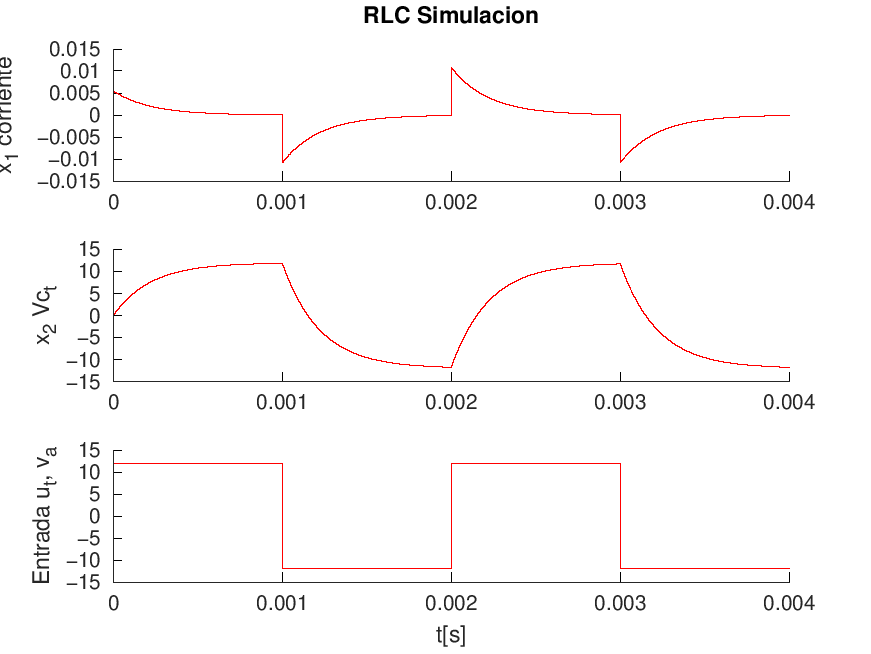

In [20]:
display.Image('rlc_numTP3.png')

#Resultados

Symbolic pkg v3.2.1: Python communication link active, SymPy v1.5.1.
Corriente = (sym)

        -t           
        ───          
         2     ⎛√3⋅t⎞
  2⋅√3⋅ℯ   ⋅sin⎜────⎟
               ⎝ 2  ⎠
  ───────────────────
           3         

Tension = (sym)

            -t               
            ───              
             2     ⎛√3⋅t   π⎞
      2⋅√3⋅ℯ   ⋅sin⎜──── + ─⎟
                   ⎝ 2     3⎠
  1 - ───────────────────────
                 3           




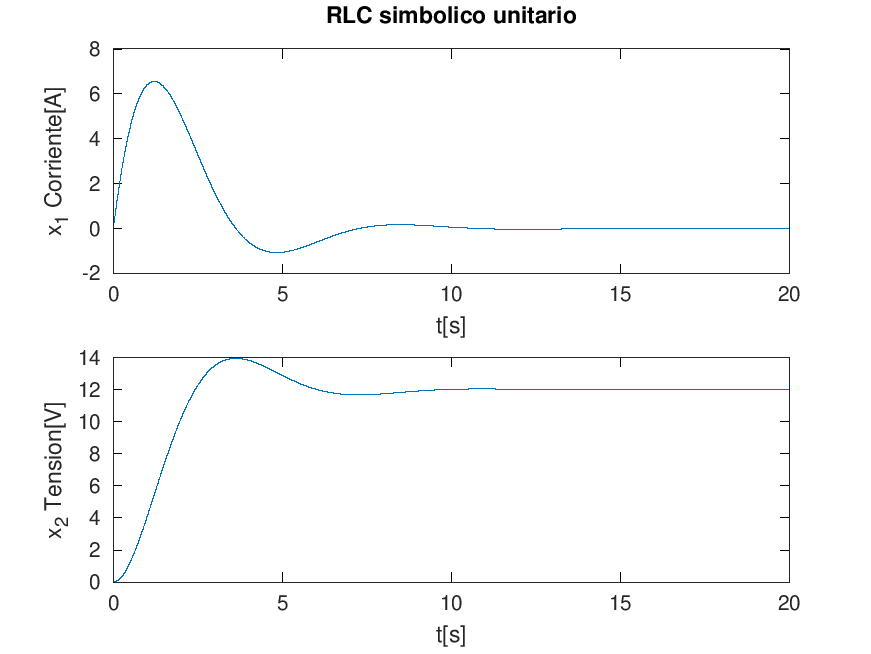

In [15]:
!octave -W Calculo_RLC_Simbolico.m # -W : no window system
display.Image('rlc_sim.png')

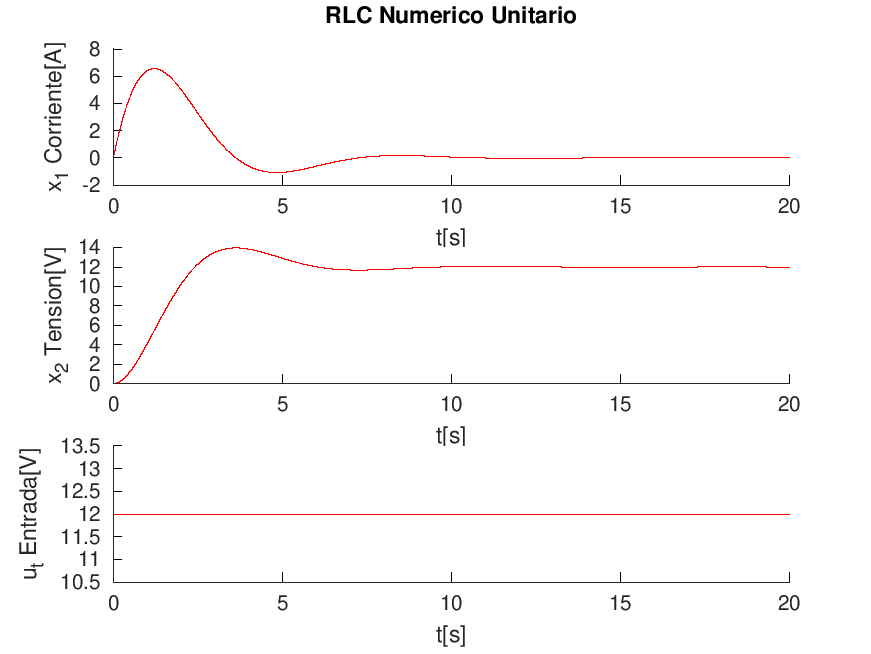

In [16]:
!octave -W Calculo_RLC_Numerico.m # -W : no window system
display.Image('rlc_num.png')

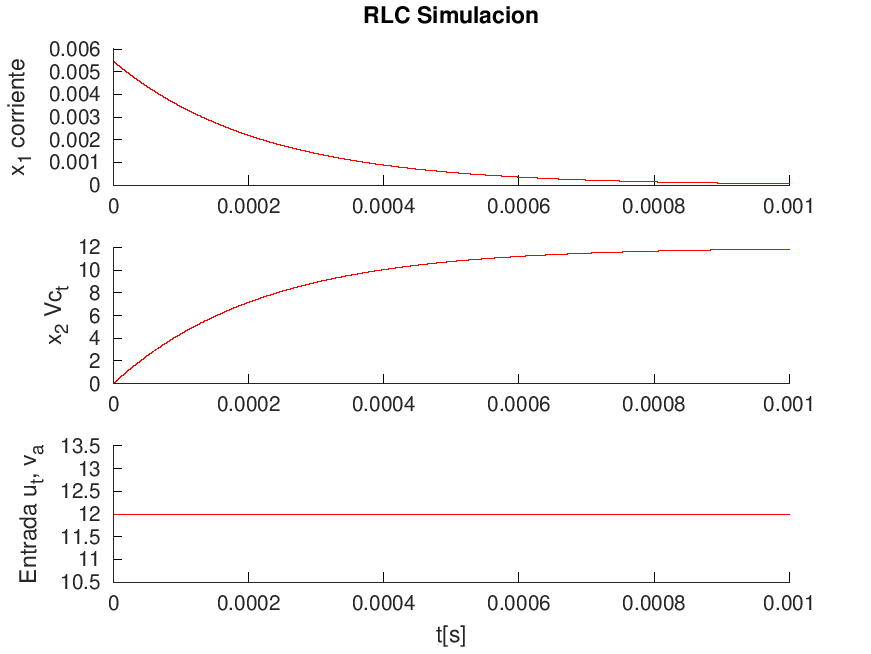

In [17]:
!octave -W Calculo_RLC_NumTP.m # -W : no window system
display.Image('rlc_numTP.png')